# Exploratory Data Analysis & Visualization

In [1]:
import os, findspark

#  Spark 4.0.1
os.environ["SPARK_HOME"] = "/opt/spark-4.0.1-bin-hadoop3"
os.environ["PATH"] = os.path.join(os.environ["SPARK_HOME"], "bin") + ":" + os.environ["PATH"]


findspark.init("/opt/spark-4.0.1-bin-hadoop3")

# create Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("JobPostingsAnalysis").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/13 15:56:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Load CSV file into Spark DataFrame

df = (
    spark.read
        .option("header", "true")
        .option("inferSchema", "true")
        .option("multiLine", "true")
        .option("escape", "\"")
        .csv("../data/lightcast_job_postings.csv")
)

In [3]:
# Fill categorical missing values
df = df.fillna({"NAICS_2022_6_NAME": "Unknown"})

# **Exploratory Data Analysis (EDA)**

### **Why we choose Choropleth Map, Stacked Bar Chart, Dual-axis Chart.**

In this job market analysis, we selected the Choropleth Map, Stacked Bar Chart, and Dual-axis Chart as the primary visualization tools. These three visualizations collectively address the key analytical dimensions of geography, employment structure, and the relationship between job demand and salary, forming a comprehensive and complementary EDA framework.

1. **Choropleth Map**

Ideal for presenting data with clear geographic attributes, such as *average salary by state*. Salaries vary significantly across different regions in the United States, and a color‐graded map provides an intuitive way to visualize spatial differences. This allows us to quickly identify high‐ and low‐salary regions and provides essential geographic context for interpreting job demand, industry concentration, and regional economic conditions.

2. **Stacked Bar Chart**

Enables simultaneous comparison of both scale and structure, making it well suited for analyzing the distribution of employment types (Full-time, Part-time, Flexible). 

Employment type has become an increasingly important dimension of today’s labor market, especially under a weakened economic climate in which many companies have reduced budgets. In such conditions, Part-time and Flexible roles may become more common as firms seek greater cost efficiency and workforce flexibility. The stacked bar chart not only highlights differences in total job postings across states but also reveals the proportional composition of these employment types.

3. **Dual-axis Chart**

Allows two metrics with different scales to be visualized together. In our analysis, it is used to present job posting volume alongside average salary for each job title, enabling us to address a central question: Do the positions with the highest market demand also offer competitive salaries? 

Job postings reflect labor market demand, while salary signals job attractiveness and skill valuation. By combining the two metrics in a single visualization, we can identify roles that are “high-demand but mid-salary,” as well as those that are “high-salary but low-demand,” thus revealing important dynamics in job-level supply and demand. 


In [4]:
from pyspark.sql import functions as F

# Remove rows with missing SALARY
df = df.filter(F.col("SALARY").isNotNull())

# Remove duplicates based on key job-identifying fields
df = df.dropDuplicates(
    subset=[
        "CITY_NAME",
        "COUNTY_NAME",
        "STATE_NAME",
        "TITLE_CLEAN",
        "COMPANY_RAW",
        "POSTED"
    ]
)


print("Rows after cleaning:", df.count())

Rows after cleaning: 30613


### **Data Cleaning and Preprocessing Strategy**


**First**, we removed all records with missing salary values, eliminating a total of 41,690 rows.

**Next**, we addressed duplicate job postings. We used six fields—city (CITY_NAME), county (COUNTY_NAME), state (STATE_NAME), job title (TITLE_CLEAN), company name (COMPANY_RAW), and posting date (POSTED) as a composite identifier for uniqueness. When all six fields are identical, the records represent the same job posting.

After applying these two filtering steps, 30,613 rows remain in the dataset. Compared with the original 72,498 rows, this represents only 42.23% of the initial data. 

## **Choropleth Map Salary Distribution by State**

In [5]:
from pyspark.sql import functions as F

# compute average state salary
state_salary = (
    df.groupBy("STATE_NAME")
      .agg(F.avg("SALARY").alias("AVG_SALARY"))
      .orderBy("AVG_SALARY", ascending=False)
)

state_salary.show(55)


+--------------------+------------------+
|          STATE_NAME|        AVG_SALARY|
+--------------------+------------------+
|         Connecticut|128023.34320987655|
|             Vermont|126231.86138613861|
|          New Jersey|125863.67491166078|
|          Washington|124996.29621621621|
|            Arkansas|124562.04406779661|
|            Virginia|124061.19700374531|
|          California|123963.91967668603|
|            Illinois|122737.81581027668|
|       Massachusetts|122488.78580990629|
|            Delaware|122415.08496732026|
|Washington, D.C. ...|121674.43347639484|
|             Montana|          120861.0|
|            Maryland|119381.37370242215|
|            Nebraska|119225.37209302325|
|            Michigan|118822.82258064517|
|      North Carolina|118158.80922431865|
|            Oklahoma|117910.32225913621|
|               Texas|117696.12257040857|
|                Iowa|117501.89523809524|
|            New York|116600.96262626263|
|             Georgia| 115984.1817

In [6]:
pdf = state_salary.toPandas()

In [7]:
import us

pdf["STATE_ABBR"] = pdf["STATE_NAME"].apply(
    lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else None
)

In [8]:
import plotly.express as px
import plotly.io as pio


pio.renderers.default = "vscode"


fig = px.choropleth(
    pdf,
    locations="STATE_ABBR",
    locationmode="USA-states",
    color="AVG_SALARY",
    color_continuous_scale="Plasma",
    scope="usa",
    labels={"AVG_SALARY": "Average Salary"},
    title="Average Salary by State"
)

fig.show()

**Figure 1. Geographic Distribution of Average Salary by State** 

This figure visualizes the average salary across U.S. states, where deep blue/purple represents lower salary levels and orange/yellow represents higher levels. The differences across states are substantial, with average salaries ranging from **$98,955 (New Mexico)** to **$128,023 (Connecticut).**

***


## 1. **Northeast Region —— High-Salary Job Markets Driven by Professional Services**

The Northeast (New England + Mid-Atlantic) appears predominantly in orange and yellow, indicating some of the highest salary levels in the country, offers a rich, competitive job market, ideal for candidates targeting finance, consulting, healthcare, academia, or professional services.


**Representative states are as following:**
- Connecticut —— $128,023 (highest nationwide)
- Vermont —— $126,232
- New Jersey —— $125,864
- Massachusetts —— $122,488
- New York —— $116,600


### **Job Market Characteristics**

1. **Strong concentration of finance, consulting, legal, and insurance sectors**
- New York remains a global financial center.
- Connecticut and New Jersey benefit from strong insurance and professional service clusters.
These industries naturally command higher salaries.

2. **Large education and healthcare markets (especially Massachusetts)**

With institutions such as Harvard, MIT, and major biomedical clusters, Massachusetts offers many high-paying academic, research, and medical positions.


3. **High urban density, diversified labor markets**

Major metropolitan areas create large and diversified job markets with abundant opportunities.


***

## **2. West Coast —— Technology-Driven High-Salary Job Markets**

The West Coast also shows strong salary performance, with states generally appearing in orange and yellow. The West Coast is the core job market for tech, engineering, and data-driven roles, featuring high salaries and strong job demand.


**Representative states:**
- California —— $123,964
- Washington —— $124,996


### **Job Market Characteristics**

1. **High concentration of technology companies**
- California: Silicon Valley, Los Angeles tech and entertainment sectors
- Washington: Headquarters of Amazon and Microsoft
The tech sector skews average salaries upward and continually demands skilled talent.

2. **Mature innovation ecosystems**

Startups and major corporations co-exist, generating many high-quality job opportunities.

3. **High urbanization (San Francisco, Los Angeles, Seattle)**

Large metropolitan areas significantly expand the job market size.

***

## **3. Great Lakes Region —— Stable Mid-High Salary Markets Supported by Healthcare & Manufacturing**

The Great Lakes region appears in mid-level orange and purple-orange shades, indicating moderate-to-high salary levels. The Great Lakes region offers balanced job markets with stable salaries and lower living costs, appealing to candidates seeking long-term stability.


**Representative states:**
- Illinois — $122,738
- Michigan — $118,822
- Wisconsin — $114,533
- Minnesota — $115,555


### **Job Market Characteristics**

1. **Major cities driving job opportunities (e.g., Chicago)**

Chicago supports finance, logistics, consulting, and healthcare, lifting the region’s salary average.

2. **Strong healthcare systems (e.g., Mayo Clinic in Minnesota)**

Healthcare positions are well-paid and stable.

3. **Established manufacturing and industrial bases (MI, WI)**

These industries offer steady job opportunities, though generally less lucrative than tech or finance.


***

## **4. Southern & Central States —— Lower-Salary Markets with Agriculture and Resource-Based Economies**

These states appear mostly in purple and deep blue, indicating lower salary levels. These regions have fewer job opportunities and fewer high-salary roles, though competition is less intense.

**Representative states:**
- New Mexico — $98,955 (lowest)
- North Dakota — $102,108
- South Dakota — $102,167
- West Virginia — $102,136
- Mississippi — $105,779

### **Job Market Characteristics**

1. **Industries dominated by agriculture, energy, and traditional sectors**

High-paying industries (tech, finance, professional services) have limited presence.


2. **Low population density and limited urbanization**

Few large metropolitan centers → fewer high-paying roles.

3. **Lower cost of living → lower compensation pressure**

Employers in these regions tend to offer lower salaries.


4. **Less diversified job markets**

Narrow industry composition reduces the availability of high-skill, high-salary jobs.


***

## **From the map, several patterns we can see:**
1. High salaries reflect mature, diversified job markets, which can be seen as Yellow / Orange ($120k+) and representative states are MA, NJ, CT, CA, WA. These regions host concentrated high-paying industries and a deep talent ecosystem.

2. Mid-level salaries reflect balanced markets, which can be seen as Purple-Orange ($110k–$120k) and representative states are IL, MI, MN. Urban centers drive opportunities but with more industrial diversity.

3. Low salaries reflect limited and less diversified markets, , which can be seen as Purple / Blue (<$110k) and representative states are NM, SD, ND, indicating fewer industries, smaller labor markets, and rural settings.



In [9]:
fig.write_html("../figure/average_salary_map.html")

# 5.1.2 Remote / Hybrid / On-site Employment Distribution by State

In [10]:
from pyspark.sql.functions import when, col, trim, upper

# Clean and rename EMPLOYMENT_TYPE_NAME
df = df.withColumn(
    "EMPLOYMENT_TYPE_CLEANED",
    when(upper(trim(col("EMPLOYMENT_TYPE_NAME"))).like("%PART-TIME / FULL-TIME%"), "Flexible")
    .when(upper(trim(col("EMPLOYMENT_TYPE_NAME"))).like("%FULL-TIME%"), "Full-time")
    .when(upper(trim(col("EMPLOYMENT_TYPE_NAME"))).like("%PART-TIME%"), "Part-time")
    .otherwise(None)
)

df.select("EMPLOYMENT_TYPE_NAME", "EMPLOYMENT_TYPE_CLEANED").distinct().show(truncate=False)

+------------------------+-----------------------+
|EMPLOYMENT_TYPE_NAME    |EMPLOYMENT_TYPE_CLEANED|
+------------------------+-----------------------+
|Part-time (â‰¤ 32 hours)|Part-time              |
|Full-time (> 32 hours)  |Full-time              |
|Part-time / full-time   |Flexible               |
+------------------------+-----------------------+



In [11]:
from pyspark.sql import functions as F

# Pivot Table（Full-time / Part-time / Flexible）distribution by State
employment_pivot = (
    df.groupBy("STATE_NAME")
      .pivot("EMPLOYMENT_TYPE_CLEANED")   
      .count()
)

# job posting by state
job_posting_count = (
    df.groupBy("STATE_NAME")
      .count()
      .withColumnRenamed("count", "job_posting")
)

# pivot table + job posting，in descending order by total job postings
employment_final = (
    employment_pivot
    .join(job_posting_count, on="STATE_NAME", how="left")
    .orderBy(F.desc("job_posting"))
)

employment_final.show(60, truncate=False)


+---------------------------------------+--------+---------+---------+-----------+
|STATE_NAME                             |Flexible|Full-time|Part-time|job_posting|
+---------------------------------------+--------+---------+---------+-----------+
|California                             |84      |3741     |134      |3959       |
|Texas                                  |23      |2428     |70       |2521       |
|New York                               |27      |1879     |74       |1980       |
|Florida                                |26      |1436     |30       |1492       |
|Virginia                               |68      |1230     |37       |1335       |
|Illinois                               |3       |1233     |29       |1265       |
|North Carolina                         |25      |877      |52       |954        |
|Colorado                               |24      |868      |45       |937        |
|Ohio                                   |10      |877      |39       |926        |
|Was

In [12]:
import plotly.graph_objects as go

# convert Spark DF to pandas
pdf = employment_final.toPandas()

# Sort by total job posting
pdf = pdf.sort_values("job_posting", ascending=False)

# Colors
colors = {
    "Full-time": "#C97B63",   
    "Part-time": "#7A9E9F",  
    "Flexible":  "#D8C690"   
}

# Create figure
fig = go.Figure()

fig.add_trace(go.Bar(
    x=pdf["STATE_NAME"],
    y=pdf["Full-time"],
    name="Full-time",
    marker_color=colors["Full-time"]
))

fig.add_trace(go.Bar(
    x=pdf["STATE_NAME"],
    y=pdf["Part-time"],
    name="Part-time",
    marker_color=colors["Part-time"]
))

fig.add_trace(go.Bar(
    x=pdf["STATE_NAME"],
    y=pdf["Flexible"],
    name="Flexible",
    marker_color=colors["Flexible"]
))

fig.update_layout(
    barmode='stack',
    title={
        'text': "Full-time / Part-time / Flexible Employment Distribution by State",
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 22, 'family': 'Arial', 'color': 'black'}
    },
    xaxis_title="State",
    yaxis_title="Number of Job Postings",
    xaxis_tickangle=45,
    legend_title="Employment Type",
    width=1400,
    height=700
)


fig.show()

**Figure 2. Full-time / Part-time / Flexible Employment Distribution by State**

Figure 2 summarizes the employment structure across states, ordered by total job postings. The data clearly show that full-time positions dominate the job market in every state, while part-time and flexible roles account for a much smaller share.

***

## **For example,** 

- California has a total of 3,959 job postings, of which 3,741 are full-time, compared with only 134 part-time and 84 flexible positions. 

- Texas displays a similar pattern with 2,521 postings, including 2,428 full-time, 70 part-time, and 23 flexible roles. 

- High-population, industry-concentrated states such as New York (1,980 total, 1,879 full-time) and Florida (1,492 total, 1,436 full-time) also reflect this full-time–dominant structure.

***

## **Across most states,**

both part-time and flexible roles remain relatively limited, typically ranging from single digits to a few dozen. For instance, North Carolina reports 954 postings with only 25 flexible and 52 part-time roles, while Georgia shows 853 postings with 14 flexible and 21 part-time positions.

Some exceptions appear in regions with specific job markets. Virginia (68 flexible roles) and Washington, D.C. (49 flexible roles) show relatively higher flexible employment, potentially due to the presence of government agencies, consulting firms, and remote-capable professional services.

Given the current economic slowdown and widespread budget reductions, part-time and flexible roles are often viewed as cost-efficient alternatives. This chart helps us evaluate whether these forms of employment are gaining traction. However, the data indicate that full-time employment remains the overwhelming majority, and flexible or part-time roles have not yet shown a significant upward shift across states.

***
Overall, this visualization highlights clear differences in job posting scale across states while revealing a consistent employment structure: the U.S. job market remains strongly full-time–driven, with limited reliance on part-time or flexible positions.

In [13]:
fig.write_html("../figure/employment_distribution_by_state.html")

# 5.1.3 Top Job Titles × Job Postings × Average Salary

In [14]:
from pyspark.sql import functions as F

# Top 15 job titles
top15_titles = (
    df.groupBy("TITLE_CLEAN")
      .agg(
          F.count("*").alias("job_postings"),
          F.avg("SALARY").alias("avg_salary")
      )
      .orderBy(F.desc("job_postings"))   # ordering by jobpostings
      .limit(15)                         
)

# ordering by average salary
top15_sorted = (
    top15_titles
      .orderBy(F.desc("avg_salary"))    
)

top15_sorted.show(15, truncate=False)


+---------------------------------------------------+------------+------------------+
|TITLE_CLEAN                                        |job_postings|avg_salary        |
+---------------------------------------------------+------------+------------------+
|data engineer analytics                            |135         |223930.24444444446|
|oracle hcm cloud manager                           |87          |184262.06896551725|
|enterprise architect                               |296         |157046.35135135136|
|oracle hcm cloud implementation lead core hr module|134         |152712.68656716417|
|solution architect                                 |105         |140712.9619047619 |
|data modeler                                       |83          |129952.15662650602|
|data analytics engineer                            |97          |124616.31958762887|
|sr data analyst                                    |105         |123114.13333333333|
|senior data analyst                                |3

In [15]:
top15_pd = top15_sorted.toPandas()

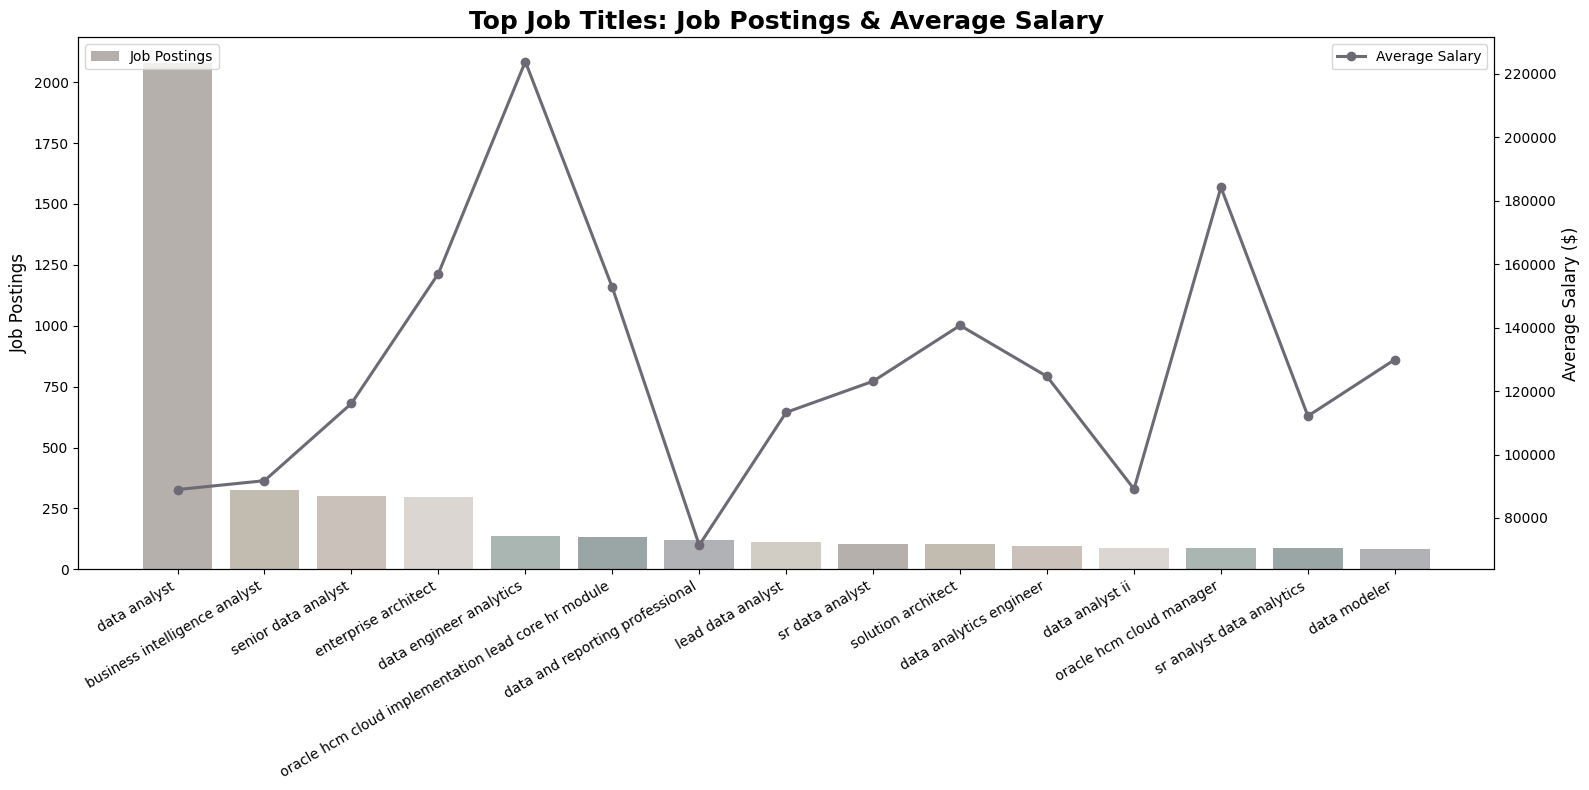

In [16]:
import matplotlib.pyplot as plt
import numpy as np

df_plot = top15_pd.sort_values("job_postings", ascending=False)


fig, ax = plt.subplots(figsize=(16, 8))


morandi_palette = [
    "#A8A39D", "#B7AFA3", "#C1B7B0", "#D6CFCB",
    "#9AA9A4", "#889696", "#A3A5A8", "#C9C5BB"
]
colors = [morandi_palette[i % len(morandi_palette)] for i in range(len(df_plot))]

# Bar Chart 
ax.bar(df_plot["TITLE_CLEAN"], df_plot["job_postings"],
       color=colors, alpha=0.85, label="Job Postings")

# Line Chart 
ax2 = ax.twinx()
ax2.plot(df_plot["TITLE_CLEAN"], df_plot["avg_salary"],
         color="#6D6A75", marker="o", linewidth=2.2, label="Average Salary")


plt.setp(ax.get_xticklabels(), rotation=30, ha="right", fontsize=10)


ax.set_title("Top Job Titles: Job Postings & Average Salary", fontsize=18, fontweight="bold")
ax.set_ylabel("Job Postings", fontsize=12)
ax2.set_ylabel("Average Salary ($)", fontsize=12)


ax.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


**Figure 3. Top 15 Job Titles: Job Postings & Average Salary**

Figure 3 presents the top 15 job titles by posting volume and compares their number of job postings with average salary using a dual-axis chart. Notably, more than 10 out of these 15 positions are analyst-related or data-focused roles, accounting for approximately 70% of the list. 

This indicates a strong and growing market demand for data analysis, business intelligence, and data-driven decision-making skills. Analyst positions have clearly become central to both technical and business-oriented job markets.

***

## **In terms of job demand,**

*data analyst* leads with 2,080 postings, significantly higher than any other role. However, its average salary of $89,848 is relatively moderate. 

### In contrast, positions that require more advanced technical skills tend to offer substantially higher salaries despite having lower posting volumes. Examples include:

- data engineer analytics: 135 postings, $223,390 average salary (highest)

- oracle hcm cloud manager: 87 postings, $184,262 average salary

- enterprise architect: 296 postings, $157,064 average salary

- data modeler: 83 postings, $129,952 average salary

### Furthermore, mid- to senior-level analyst roles show a clear “skill elevation indicates salary increase” pattern, highlighting the salary premium associated with advanced analytical expertise:

- sr data analyst: 86 postings, $112,346 average salary

- lead data analyst: 114 postings, $113,385 average salary

- business intelligence analyst: 326 postings, $97,146 average salary

These salaries are all higher than that of the entry-level data analyst role, demonstrating the market’s strong valuation of deeper analytical capabilities, technical proficiency, and business insight.

***

## Overall, Figure 3 reveals two key insights:

1. High-demand roles are heavily concentrated in analyst, data, and BI categories, reflecting the job market’s accelerating shift toward data-driven talent.

2. Job demand and salary are not strictly correlated. 

Highly demanded roles like data analyst offer stable but not outstanding salaries, while moderately demanded but highly technical roles—such as data engineer or enterprise architect—command significantly higher pay, illustrating the market premium on specialized skills.

In [17]:
plt.savefig("../figure/top15_jobtitles_dualaxis.png", dpi=300, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

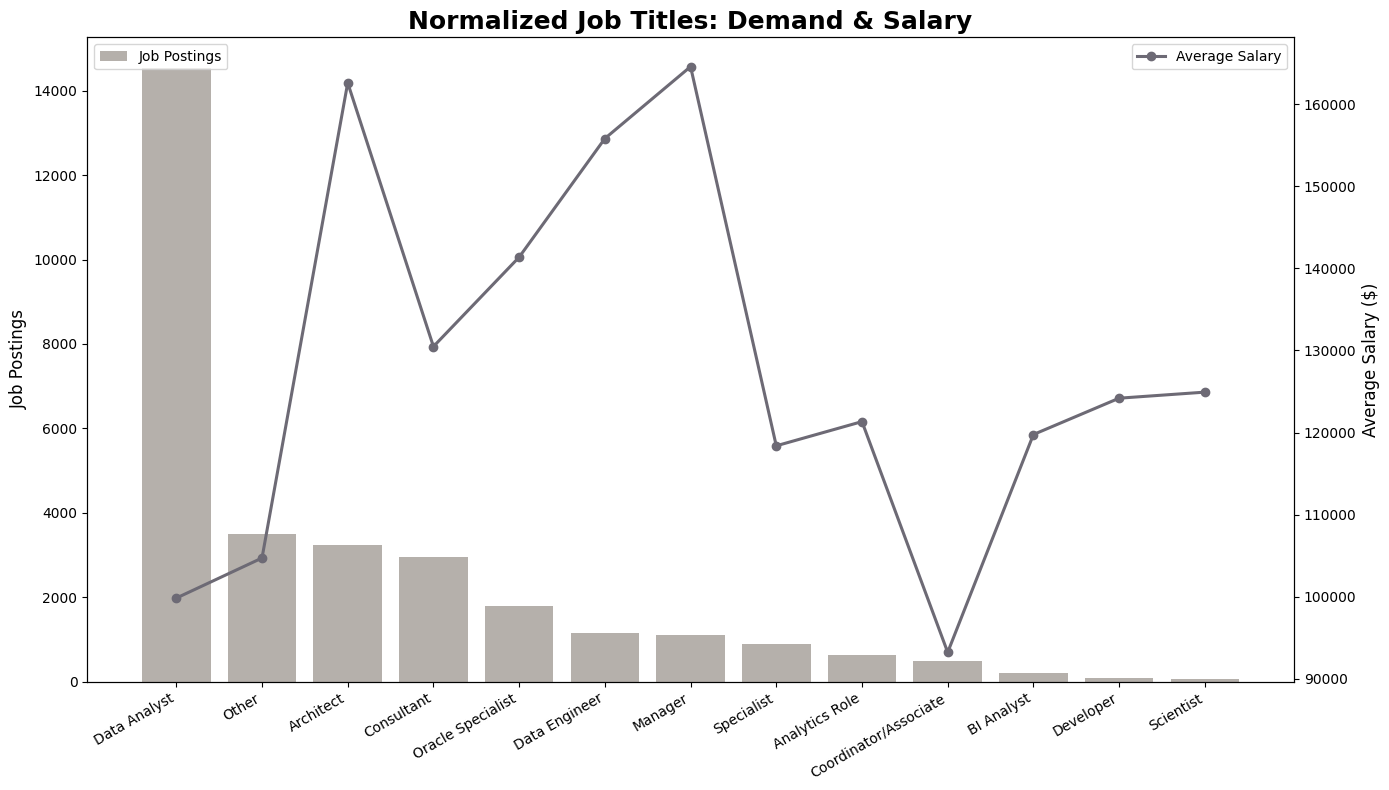

In [18]:
# Proposed fix....

# Load required libraries
from pyspark.sql import functions as F
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define normalization function
def normalize_title(title):
    if title is None:
        return "Other"

    title = title.lower()
    if "manager" in title:
        return "Manager"
    elif "data scientist" in title or "scientist" in title:
        return "Scientist"
    elif "data engineer" in title or "engineer" in title:
        return "Data Engineer"
    elif "data analyst" in title or "analyst" in title:
        return "Data Analyst"
    elif "bi analyst" in title or "business intelligence" in title:
        return "BI Analyst"
    elif "developer" in title:
        return "Developer"
    elif "architect" in title:
        return "Architect"
    elif "oracle" in title:
        return "Oracle Specialist"
    elif "consultant" in title:
        return "Consultant"
    elif "specialist" in title:
        return "Specialist"
    elif "coordinator" in title or "associate" in title:
        return "Coordinator/Associate"
    elif "analytics" in title:
        return "Analytics Role"
    else:
        return "Other"

# Register as UDF
normalize_title_udf = F.udf(normalize_title, StringType())

# Apply normalization
df_normalized = df.withColumn("TITLE_GROUPED", normalize_title_udf(F.col("TITLE_CLEAN")))

# Aggregate by normalized title
grouped_titles = (
    df_normalized.groupBy("TITLE_GROUPED")
    .agg(
        F.count("*").alias("job_postings"),
        F.avg("SALARY").alias("avg_salary")
    )
    .filter(F.col("job_postings") >= 50)  # Optional threshold
)

# Variable sorting prior to formatting
grouped_titles = grouped_titles.orderBy(F.desc("job_postings")) # Alternatives: 1) grouped_titles = grouped_titles.orderBy(F.desc("avg_salary")) , or: 2)grouped_titles = grouped_titles.orderBy("TITLE_GROUPED")

# Output formatting
grouped_titles = (
    grouped_titles
    .withColumn("avg_salary", F.round(F.col("avg_salary"), 2))
    .withColumn("avg_salary", F.format_number("avg_salary", 2))
    .withColumn("job_postings", F.format_number("job_postings", 0))
)

# Convert to Pandas for display or plotting
grouped_titles.toPandas()
pdf = grouped_titles.toPandas()

# Convert formatted strings back to numeric
pdf["avg_salary"] = pdf["avg_salary"].str.replace(",", "").astype(float)
pdf["job_postings"] = pdf["job_postings"].str.replace(",", "").astype(int)

# Sort by job postings descending
pdf = pdf.sort_values("job_postings", ascending=False)

# Plot setup
fig, ax1 = plt.subplots(figsize=(14, 8))

# Bars for job postings
ax1.bar(
    pdf["TITLE_GROUPED"],
    pdf["job_postings"],
    color="#A8A39D",
    alpha=0.85,
    label="Job Postings"
)

# Line for salary
ax2 = ax1.twinx()
ax2.plot(
    pdf["TITLE_GROUPED"],
    pdf["avg_salary"],
    color="#6D6A75",
    marker="o",
    linewidth=2.2,
    label="Average Salary"
)

# Rotate labels for readability
plt.setp(ax1.get_xticklabels(), rotation=30, ha="right", fontsize=10)

# Axis labels
ax1.set_ylabel("Job Postings", fontsize=12)
ax2.set_ylabel("Average Salary ($)", fontsize=12)

# Title
plt.title("Normalized Job Titles: Demand & Salary", fontsize=18, fontweight="bold")

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

# Answer:

## **Figure 3. Normalized Job Titles: Job Postings & Average Salary**

Figure 3 presents a dual-axis chart comparing the number of job postings (bars) and average salary (line) across 13 normalized job title categories. These categories were derived from a custom title normalization function applied to over 25,000 postings, grouping similar roles under consistent labels such as *Data Analyst*, *Architect*, and *Oracle Specialist*. The chart is sorted by job posting volume, highlighting the most common roles in the dataset.

Notably, **Data Analyst** dominates the landscape with **14,538 postings**, accounting for more than 40% of the total sample. This confirms the centrality of analytical literacy in today’s job market, where data fluency is increasingly a baseline requirement across industries.

---

## **In terms of job demand:**

- **Data Analyst** leads by a wide margin, followed by *Other*, *Architect*, and *Consultant*.  
- These top four categories alone represent over 60% of all postings, underscoring the dominance of analyst, architect, and consulting roles in the data ecosystem.

### However, salary patterns tell a different story:

- **Manager** and **Architect** roles offer the highest average salaries — **$164,558** and **$162,582**, respectively — despite having fewer postings than Data Analyst.  
- **Data Engineer** and **Oracle Specialist** also command strong compensation, averaging **$155,801** and **$141,360**, respectively.  
- These roles typically require deeper technical expertise, system-level thinking, and cross-functional leadership — all of which drive salary premiums.

---

## **Mid-tier roles show a clear skill-to-salary gradient:**

- **Consultant**, **Scientist**, and **Developer** roles average between **$124,000–130,000**, reflecting specialized technical or advisory functions.  
- **Analytics Role**, **BI Analyst**, and **Specialist** fall in the **$118,000–121,000** range, suggesting moderate compensation for hybrid business-technical positions.  
- **Coordinator/Associate** roles average **$93,248**, consistent with entry-level or support functions.

---

## **Key insights from Figure 3:**

1. **Job demand is heavily concentrated in analyst and architect categories**, reflecting the market’s appetite for data-driven decision-making and system design expertise.

2. **Salary and demand are not tightly correlated.**  
   High-demand roles like *Data Analyst* offer stable but moderate pay, while lower-volume roles like *Manager* and *Architect* command significantly higher salaries — illustrating the premium placed on leadership, infrastructure, and specialized technical skills.